<a href="https://colab.research.google.com/github/GriffinPlecko/PyTorch-Repository/blob/main/Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Convert MNIST Image files into Tensor of 4D (Number of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [5]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21951678.75it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 642190.19it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5516208.62it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8304502.51it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [6]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
# Create a small batch size for images, 10 for this example
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [11]:
# Define our CNN Model
# Describe concolutional layer and what it's doing, end up with 2 layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [12]:
# Grab 1 MNIST Image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [14]:
X_Train.shape

torch.Size([1, 28, 28])

In [15]:
# Make 4d Batch
x = X_Train.view(1,1,28,28)

In [16]:
# Perform the First Convolution
x = F.relu(conv1(x))

In [17]:
# 1 Single Image, 6 Filters / Feature Maps, 26x26 Image (Unnecessary Padding is ignored)
x.shape

torch.Size([1, 6, 26, 26])

In [18]:
# Pooling Layer
x = F.max_pool2d(x,2,2) # Kernal of 2 and Stride of 2

In [19]:
# 13x13 26 / 2 = 13
x.shape

torch.Size([1, 6, 13, 13])

In [20]:
# 2nd Convolutional Layer
x = F.relu(conv2(x))

In [21]:
# 11x11 (Lose 2px of Padding)
x.shape

torch.Size([1, 16, 11, 11])

In [22]:
# 2nd Pooling Layer
x = F.max_pool2d(x,2,2)

In [23]:
# 11 / 2 = 5.5 but round down, data cannot round up (cannot bring back other half of image)
x.shape

torch.Size([1, 16, 5, 5])

In [24]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  # Forward Function
  def forward(self, X):
    X = F.relu(conv1(X))
    X = F.max_pool2d(X,2,2)
    # Second Pass
    X = F.relu(conv2(X))
    X = F.max_pool2d(X,2,2)

    # Re-View to Flatten out data
    X = X.view(-1, 16*5*5) # Negative 1 allows a varied batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X) # No need for RELU on last layer
    return F.log_softmax(X, dim=1)

In [25]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller Learning Rate means Longer Training Time


In [28]:
import time
start_time = time.time()

# Create Variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b,(X_Train, y_train) in enumerate(train_loader):
    b+=1 # Start our batches at 1
    y_pred = model(X_Train) # Get predicted values from the training dataset
    loss = criterion(y_pred, y_train) # Compare Predictions to correct answers

    predicted = torch.max(y_pred.data, 1)[1] # Add up the number of correct predictions, indexed off the first point
    batch_corr = (predicted == y_train).sum() # How many we got correct from specific batch, True=1 False=0
    trn_corr += batch_corr # Keep track as we train

    # Update Parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print Out Results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.4438657760620117
Epoch: 0 Batch: 1200 Loss: 0.2075366973876953
Epoch: 0 Batch: 1800 Loss: 0.19731584191322327
Epoch: 0 Batch: 2400 Loss: 0.409282922744751
Epoch: 0 Batch: 3000 Loss: 0.02449696883559227
Epoch: 0 Batch: 3600 Loss: 0.10141193866729736
Epoch: 0 Batch: 4200 Loss: 0.47303080558776855
Epoch: 0 Batch: 4800 Loss: 0.05855650454759598
Epoch: 0 Batch: 5400 Loss: 0.18790075182914734
Epoch: 0 Batch: 6000 Loss: 0.0645722970366478
Epoch: 1 Batch: 600 Loss: 0.15362292528152466
Epoch: 1 Batch: 1200 Loss: 0.02607959508895874
Epoch: 1 Batch: 1800 Loss: 0.6440801024436951
Epoch: 1 Batch: 2400 Loss: 1.0615321397781372
Epoch: 1 Batch: 3000 Loss: 0.018126964569091797
Epoch: 1 Batch: 3600 Loss: 0.018161891028285027
Epoch: 1 Batch: 4200 Loss: 0.010210555978119373
Epoch: 1 Batch: 4800 Loss: 0.002681776648387313
Epoch: 1 Batch: 5400 Loss: 0.0972585678100586
Epoch: 1 Batch: 6000 Loss: 0.3045622706413269
Epoch: 2 Batch: 600 Loss: 0.17196716368198395
Epoch: 2 Batch: 1200 

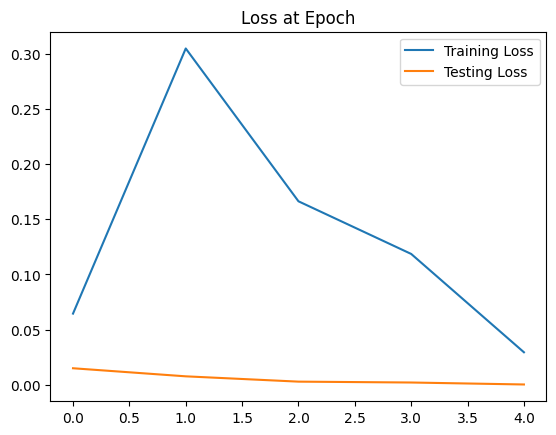

In [29]:
# Graph the loss at each Epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

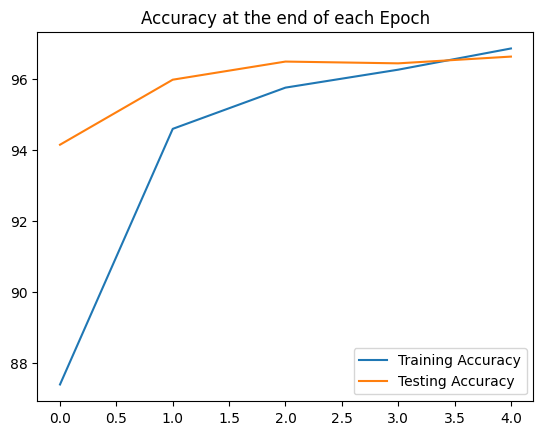

In [30]:
# Graph the accuracy at the end of each Epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the end of each Epoch')
plt.legend()

In [31]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [32]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [33]:
# Test for correct
correct.item()

9663

In [34]:
# Grab an Image
test_data[4143] # Tensor with an image in it, at the end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [35]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [36]:
# Reshape data
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

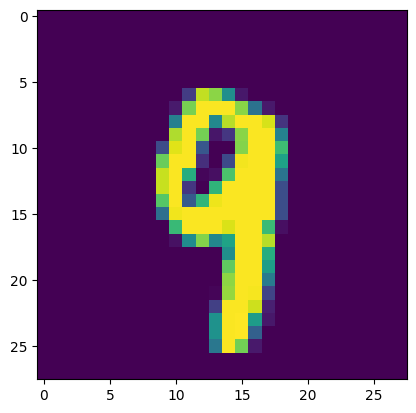

In [37]:
# Show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [39]:
# Pass the image through our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) # Batch size of 1, 1 color channel, 28x28 image

In [40]:
# Check the new prediction and get probabilities
new_prediction

tensor([[-1.6223e+01, -1.8126e+01, -1.4964e+01, -1.2149e+01, -6.8003e+00,
         -1.0236e+01, -2.5244e+01, -6.9626e+00, -1.0639e+01, -2.1278e-03]])

In [41]:
new_prediction.argmax()

tensor(9)